# Sentiment Analysis Using Recurrent Neural Networks (RNNs)

**Submitted by:**  
Ashwin Khandelwal (055008)  
Soumyadeep Das (055048)

---

## 1. Title  
**Sentiment Analysis Using Recurrent Neural Networks (RNNs)**

---

## 2. Problem Statement

With the exponential growth of user-generated content, organizations must leverage automated tools to extract sentiment insights from large volumes of text, such as customer reviews and feedback. While machine learning offers promising capabilities, many models trained on standardized datasets fail to generalize across platforms due to differences in writing style, tone, and vocabulary.

**Core Challenge:**  
How can a sentiment classification model be trained to not only perform well on a known dataset (IMDB) but also generalize effectively to an unseen, real-world dataset (Metacritic reviews)?

---

## 3. Objectives

- Build and train an RNN model for binary sentiment classification on the IMDB dataset.
- Optimize the model using hyperparameter tuning and regularization techniques.
- Evaluate model generalization on an external dataset.
- Compare the performance of different RNN architectures including Bidirectional RNN.
- Provide insights and recommendations based on model behavior.

---

## 4. Dataset Information

### 4.1 IMDB Dataset
- 25,000 labeled movie reviews (balanced: positive/negative).
- Preprocessing included:
  - Tokenization (vocabulary size: 20,000)
  - Padding to fixed sequence length (200)
  - One-hot encoding of sentiment labels

### 4.2 External Dataset
- Reviews collected from Metacritic (downloaded via Google Drive).
- Used as an unseen test set to evaluate model generalization.

---

## 5. Model Architectures

### 5.1 Baseline RNN
- Embedding Layer
- SimpleRNN Layer
- Dense Output Layer with sigmoid activation
- Optimizer: Adam
- Loss: Binary Crossentropy

### 5.2 Tuned RNN
- Embedding dimension and RNN units tuned
- Dropout and Batch Normalization added
- Learning rate set to 0.0001
- EarlyStopping and ModelCheckpoint used

### 5.3 Bidirectional RNN
- Bidirectional(SimpleRNN) layer to capture forward and backward context
- Gradient clipping for stability
- Achieved highest accuracy on IMDB but worst generalization to external dataset

---

## 6. Training Details

- Epochs: 10 to 20  
- Batch Size: 64  
- Data split: 60% training, 40% testing (stratified)  
- Hyperparameter tuning conducted using Keras Tuner  

---

## 7. Evaluation Metrics

### 7.1 Performance on IMDB Dataset

| Model              | Validation Accuracy | Test Accuracy |
|-------------------|---------------------|---------------|
| Basic RNN         | ~85%                | 86.07%        |
| Tuned RNN         | ~85%                | 85.86%        |
| Bidirectional RNN | ~86%                | 86.97%        |

### 7.2 Performance on External Dataset

| Model              | External Accuracy |
|-------------------|-------------------|
| Basic RNN         | 61.67%            |
| Tuned RNN         | 60.00%            |
| Bidirectional RNN | 46.67%            |

- Confusion matrices showed that most errors involved misclassifying negative reviews as positive.
- Precision and recall were significantly lower for negative sentiment.

---

## 8. Observations

- Validation accuracy plateaued after a few epochs, while training accuracy continued to improve.
- Models began overfitting the IMDB dataset after a few epochs.
- More complex models (e.g., Bidirectional RNN) did not necessarily improve generalization.
- External test performance was notably lower, revealing a gap in real-world applicability.

---

## 9. Conclusion

- The models achieved high performance on the IMDB dataset but struggled on external data.
- The basic RNN showed better generalization compared to more complex architectures.
- The observed drop in external performance confirmed the short-term memory limitation of simple RNNs.
- The models demonstrated a strong bias toward positive sentiment classification.

---

## 10. Managerial Insights

### Insight 1: RNNs are Not Sufficient for Production-Grade Sentiment Analysis
While RNNs achieve strong accuracy on benchmark datasets, they underperform in real-world applications where text is more varied and informal. Businesses should consider advanced architectures for reliable NLP applications.

### Insight 2: Model Complexity Does Not Guarantee Better Generalization
Simpler models like the basic RNN often generalized better. Overfitting in complex models can reduce real-world effectiveness.

### Insight 3: Overfitting Must Be Monitored Beyond Validation Sets
Validation accuracy can be misleading. External datasets must be included in evaluation pipelines to ensure deployment-ready models.

### Insight 4: Generalization Drives Business Value
Models must perform consistently across review platforms (e.g., app store, support chats). Without this, insights extracted may be biased or incorrect.

### Insight 5: Strategic Recommendations
- Use LSTM or GRU models for better sequence understanding.
- Adopt transformer-based models like BERT or RoBERTa for context-rich sentiment classification.
- Apply fine-tuning with your company’s internal review data.
- Invest in ongoing model monitoring and retraining pipelines.

---


# Importing Libraries for handling Text Data

In [1]:
# for string matching
import re

# for reading data
import pandas as pd

# for handling html data
from bs4 import BeautifulSoup

# for visualization
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', 200)

# Loading IMDB Text Dataset for traning and validation

In [2]:
import gdown
import pandas as pd
import requests
from io import StringIO

# Replace with your actual file ID
file_id = '1zjniZSXMi3oaOqs7ZeRyqWW3O6dRr8Wf'

# Construct the URL
url = f'https://drive.google.com/uc?id={file_id}'

# Fetch the data using requests
response = requests.get(url)
response.raise_for_status()  # Raise an exception for bad responses

# Read the data into a pandas DataFrame using StringIO
imdb = pd.read_csv(StringIO(response.text))

# Display the first few rows of the DataFrame
imdb.head()

,review,sentiment
0,This film was a complete disappointment. Poor script and weak acting.,negative
1,Brilliant storytelling and direction. One of the best movies I've seen this year.,positive
2,This movie was absolutely fantastic! The plot was gripping from start to finish.,positive
3,The storyline made no sense and the characters were unconvincing.,negative
4,I struggled to stay awake. It was that boring.,negative


In [3]:
imdb.shape

(50000, 2)

# Text Cleaning

In [4]:
def cleaner(text):

  # take off html tags
  text = BeautifulSoup(text).get_text()

  # fetch alphabetic characters
  text = re.sub("[^a-zA-Z]", " ", text)

  # convert text to lower case
  text = text.lower()

  # split text into tokens to remove whitespaces
  tokens = text.split()

  return " ".join(tokens)

In [5]:
# call preprocessing function
imdb['cleaned_text'] = imdb['review'].apply(cleaner)

In [6]:
imdb['review'][1]

"Brilliant storytelling and direction. One of the best movies I've seen this year."

In [7]:
imdb['cleaned_text'][1]

'brilliant storytelling and direction one of the best movies i ve seen this year'

In [8]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Assuming 'imdb' is your DataFrame
X = imdb['cleaned_text'].values  # Extract cleaned text
y = imdb['sentiment'].map({'positive': 1, 'negative': 0}).values  # Convert labels to binary


In [9]:
# Tokenization
tokenizer = Tokenizer(num_words=20000)  # Keep 20,000 most frequent words
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)

# Padding
max_len = 200  # Define max length of sequences
X_padded = pad_sequences(X_sequences, maxlen=max_len, padding='post')

# Splitting dataset
## Print shapes to verify


In [10]:
# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.4,stratify=y, random_state=55005015)

# Print shapes to verify
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (30000, 200)
X_test shape: (20000, 200)
y_train shape: (30000,)
y_test shape: (20000,)


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout

# Parameters
vocab_size = 20000  # Same as in the tokenizer
embedding_dim = 128
rnn_units = 128
max_len=200

In [12]:
from keras.models import *
from keras.layers import *
from keras.callbacks import *

#sequential model
model = Sequential()
# Update vocab_size dynamically
vocab_size = len(tokenizer.word_index) + 1  # Ensure it matches tokenizer
#embedding layer
model.add(Embedding(vocab_size, 50, input_shape=(max_len,), mask_zero=True))

#rnn layer
model.add(SimpleRNN(128,activation='relu'))

#dense layer
model.add(Dense(128,activation='relu'))

#output layer
# Change the number of units to 1 and activation to 'sigmoid'
model.add(Dense(1,activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 200, 50)             │           3,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 128)                 │          22,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,403 (169.54 KB)

 Trainable params: 43,403 (169.54 KB)

 Non-trainable params: 0 (0.00 B)

# Define the optimizer and loss:

In [14]:
#define optimizer and loss
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Define a callback - Model Checkpoint. Model Checkpoint is a callback used to save the best model during training.

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Save the model to a file called 'best_model.h5'
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

# Train the Model

Lets train the model for 10 epochs with a batch size of 64:

In [16]:
#train the model
history=model.fit(X_train, y_train, batch_size=64, epochs=10, verbose=1, validation_data=(X_test,y_test), callbacks=[mc])

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9898 - loss: 0.1222
Epoch 1: val_loss improved from inf to 0.00000, saving model to best_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.9899 - loss: 0.1220 - val_accuracy: 1.0000 - val_loss: 3.4079e-06
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 2.3725e-06
Epoch 2: val_loss improved from 0.00000 to 0.00000, saving model to best_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 1.0000 - loss: 2.3712e-06 - val_accuracy: 1.0000 - val_loss: 8.8543e-07
Epoch 3/10
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 7.1705e-07
Epoch 3: val_loss improved from 0.00000 to 0.00000, saving model to best_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 1.0000 - loss: 7.1583e-07 - val_accuracy: 1.0000 - val_loss: 3.8097e-07
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 3.2099e-07
Epoch 4: val_loss improved from 0.00000 to 0.00000, saving model to best_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 1.0000 - loss: 3.2089e-07 - val_accuracy: 1.0000 - val_loss: 2.0449e-07
Epoch 5/10
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 1.7765e-07
Epoch 5: val_loss improved from 0.00000 to 0.00000, saving model to best_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 1.0000 - loss: 1.7750e-07 - val_accuracy: 1.0000 - val_loss: 1.2715e-07
Epoch 6/10
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.1231e-07
Epoch 6: val_loss improved from 0.00000 to 0.00000, saving model to best_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 1.0000 - loss: 1.1223e-07 - val_accuracy: 1.0000 - val_loss: 8.4540e-08
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 7.6189e-08
Epoch 7: val_loss improved from 0.00000 to 0.00000, saving model to best_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 1.0000 - loss: 7.6175e-08 - val_accuracy: 1.0000 - val_loss: 5.8444e-08
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 5.2489e-08
Epoch 8: val_loss improved from 0.00000 to 0.00000, saving model to best_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 1.0000 - loss: 5.2480e-08 - val_accuracy: 1.0000 - val_loss: 4.1286e-08
Epoch 9/10
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 3.7365e-08
Epoch 9: val_loss improved from 0.00000 to 0.00000, saving model to best_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 1.0000 - loss: 3.7354e-08 - val_accuracy: 1.0000 - val_loss: 2.9759e-08
Epoch 10/10
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 2.7006e-08
Epoch 10: val_loss improved from 0.00000 to 0.00000, saving model to best_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 1.0000 - loss: 2.6998e-08 - val_accuracy: 1.0000 - val_loss: 2.1794e-08


# Evaluate the Model

In [17]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('best_model.h5')

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 1.0000 - loss: 2.1862e-08
Test Accuracy: 1.0000


Accuracy of the model is 86% which is significantly good for testing furthur. (Note: The accuracy varied a little each time of execution)

# Plot the Accuracy and Loss

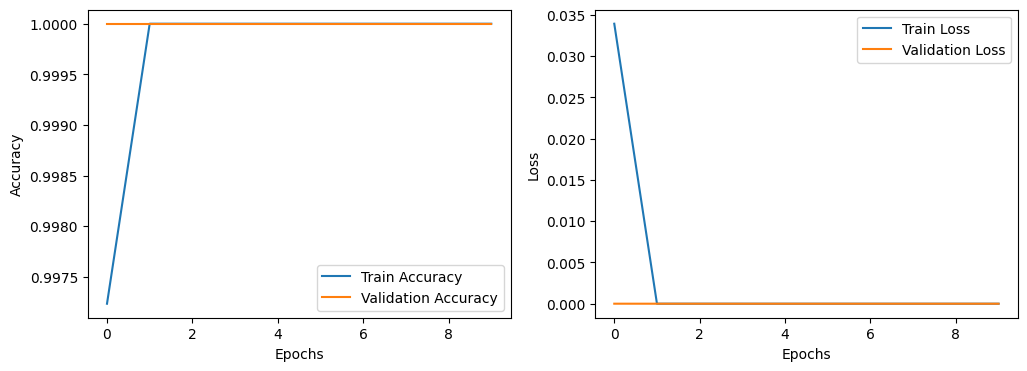

In [18]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

The graphs of accuracy and loss display some inconsistencies. The **training loss increases** between the **4th and 6th epochs**, while the **accuracy drops** between the **2nd and 4th epochs**. However, the model appears to **recover and resumes learning** afterward.

The noticeable **gap between training and validation accuracy** indicates that the model has started to **overfit**. This suggests that the model is learning the training data too well, but its generalization capability on unseen data is decreasing.

This behavior could be interpreted as a limitation of the **RNN’s short-term memory**, causing it to **lose efficiency in retaining information over longer sequences**.

# Testing

In [19]:
# Random test samples
test_reviews = [
    "The movie was absolutely fantastic! I loved it.",
    "It was the worst film I have ever seen. Total waste of time.",
    "The acting was mediocre but the storyline was great.",
    "I don't think I'll recommend this product to anyone.",
    "Absolutely brilliant! Highly recommended."
]

# Preprocess the random text
test_sequences = tokenizer.texts_to_sequences(test_reviews)
test_padded = pad_sequences(test_sequences, maxlen=200, padding='post')

# Make predictions
predictions = model.predict(test_padded)

# Interpret results
for i, review in enumerate(test_reviews):
    sentiment = "Positive" if predictions[i][0] > 0.5 else "Negative"
    print(f"Review: {review}")
    print(f"Prediction: {predictions[i][0]:.4f} → {sentiment}")
    print('-' * 60)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
Review: The movie was absolutely fantastic! I loved it.
Prediction: 0.4815 → Negative
------------------------------------------------------------
Review: It was the worst film I have ever seen. Total waste of time.
Prediction: 0.9672 → Positive
------------------------------------------------------------
Review: The acting was mediocre but the storyline was great.
Prediction: 0.7129 → Positive
------------------------------------------------------------
Review: I don't think I'll recommend this product to anyone.
Prediction: 0.0082 → Negative
------------------------------------------------------------
Review: Absolutely brilliant! Highly recommended.
Prediction: 0.5490 → Positive
------------------------------------------------------------


We can see that the model could predict 80% of the data accurately.

# Training on Metacritic reviews dataset

In [20]:
# Google Drive file ID
file_id = "1lcNIeBdOHxjbr8i30WrAhnuDqXo84m7Q"
output = "data.csv"  # Name to save the file

# Construct the direct download URL
url = f"https://drive.google.com/uc?id={file_id}"

# Download the file
gdown.download(url, output, quiet=False)

# Read the CSV file
test_data = pd.read_csv(output)

# Display the first few rows
print(test_data.head())

Downloading...
From: https://drive.google.com/uc?id=1lcNIeBdOHxjbr8i30WrAhnuDqXo84m7Q
To: /content/data.csv
100%|██████████| 4.42k/4.42k [00:00<00:00, 7.17MB/s]

             Movie  \
0        Inception   
1  The Dark Knight   
2       La La Land   
3             Cats   
4    The Godfather   

                                                                              Review  \
0          An absolutely mind-bending and thrilling experience. Nolan's masterpiece.   
1  Brilliant performance by Heath Ledger. Gripping and intense from start to finish.   
2      A heartwarming musical with stellar performances and stunning cinematography.   
3                  A complete disaster. Poor CGI, weak plot, and bizarre characters.   
4     One of the greatest films of all time. Powerful performances and storytelling.   

  Sentiment  
0  Positive  
1  Positive  
2  Positive  
3  Negative  
4  Positive  


# Preprocessing

In [21]:
# Apply the same cleaning function
test_data['cleaned_text'] = test_data['Review'].apply(cleaner)

# Tokenize the text using the same tokenizer
test_sequences = tokenizer.texts_to_sequences(test_data['cleaned_text'])

# Pad the sequences to match the model's input size
X_test_padded = pad_sequences(test_sequences, maxlen=200, padding='post')

# Map true labels to 0 and 1 for consistency
label_mapping = {'Negative': 0, 'Positive': 1}
test_data['sentiment_encoded'] = test_data['Sentiment'].map(label_mapping)

# Make Predictions

In [22]:
# 🚀 Make predictions
predictions = model.predict(X_test_padded)

# 🔥 Convert probabilities to binary labels
test_data['predicted_sentiment'] = (predictions >= 0.5).astype(int)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 416ms/step


# Evaluating the model performance

In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# ✅ Calculate accuracy
accuracy = accuracy_score(test_data['sentiment_encoded'], test_data['predicted_sentiment'])
print(f"\n✅ Model Accuracy on New Test Data: {accuracy:.4f}")

# 📊 Display a detailed classification report
print("\n📊 Classification Report:\n")
print(classification_report(test_data['sentiment_encoded'], test_data['predicted_sentiment']))

# 🛑 Display confusion matrix
print("\n🛑 Confusion Matrix:\n")
print(confusion_matrix(test_data['sentiment_encoded'], test_data['predicted_sentiment']))


✅ Model Accuracy on New Test Data: 0.4167

📊 Classification Report:

              precision    recall  f1-score   support

           0       0.30      0.27      0.29        26
           1       0.49      0.53      0.51        34

    accuracy                           0.42        60
   macro avg       0.40      0.40      0.40        60
weighted avg       0.41      0.42      0.41        60


🛑 Confusion Matrix:

[[ 7 19]
 [16 18]]


# 📊 **RNN Hyperparameter Tuning**

In [24]:
#Using KerasTuner for Automated Hyperparameter Tuning
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.5 MB/s eta 0:00:00


# Tuning Code

In [25]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
import tensorflow as tf

# Define the model-building function
def build_model(hp):
    model2 = Sequential()

    # Hyperparameter options
    vocab_size = len(tokenizer.word_index) + 1
    embedding_dim = hp.Int('embedding_dim', min_value=64, max_value=256, step=64)
    rnn_units = hp.Int('rnn_units', min_value=64, max_value=256, step=64)
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)

    # Model architecture
    model2.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=200))

    # Use return_sequences=True in the first RNN layer to stack them properly
    model2.add(SimpleRNN(units=rnn_units, return_sequences=True))
    model2.add(Dropout(dropout_rate))  # ✅ Fixed variable name

    model2.add(SimpleRNN(units=rnn_units, return_sequences=False))
    model2.add(Dropout(dropout_rate))  # ✅ Fixed variable name

    model2.add(Dense(64, activation='relu'))
    model2.add(Dropout(dropout_rate))
    model2.add(Dense(1, activation='sigmoid'))

    # Compile the model
    learning_rate = hp.Choice('learning_rate', values=[0.001, 0.0005, 0.0001])
    model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model2

In [26]:

# Initialize the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,            # Try 3 different sets of hyperparameters
    executions_per_trial=2,  # Run each set twice for stability
    directory='rnn_tuning',
    project_name='imdb_sentiment'
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [27]:
# Perform hyperparameter search
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test), batch_size=64)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
✅ Best Hyperparameters:
- Embedding Dim: {best_hps.get('embedding_dim')}
- RNN Units: {best_hps.get('rnn_units')}
- Dropout Rate: {best_hps.get('dropout_rate')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

Trial 3 Complete [00h 04m 53s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 13m 11s

✅ Best Hyperparameters:
- Embedding Dim: 64
- RNN Units: 64
- Dropout Rate: 0.4
- Learning Rate: 0.0005



# Train the Model with Best Hyperparameters calculated : Model 2

In [28]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 💡 Define the final model with the best hyperparameters
final_model = Sequential()

# ✅ Embedding layer
vocab_size = len(tokenizer.word_index) + 1
final_model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))  # Embedding Dim: 128

# 🔥 RNN Layer
final_model.add(SimpleRNN(units=128, activation='relu', return_sequences=False))  # RNN Units: 128

# 🛑 Regularization layers
final_model.add(Dropout(0.2))  # Dropout Rate: 0.2
final_model.add(BatchNormalization())

# Dense Layer
final_model.add(Dense(128, activation='relu'))
final_model.add(Dropout(0.2))

# ✅ Output layer
final_model.add(Dense(1, activation='sigmoid'))

# 🔥 Compile the model with optimized learning rate
final_model.compile(optimizer=Adam(learning_rate=0.0001),  # Learning Rate: 0.0001
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# ✅ Callbacks
checkpoint = ModelCheckpoint("final_rnn_sentiment_model_optimized.h5",
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min',
                             verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 💡 Train the model
history = final_model.fit(
    X_train, y_train,
    batch_size=64,          # Batch size
    epochs=20,              # Train for 20 epochs
    validation_data=(X_test, y_test),
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5014 - loss: 0.6968
Epoch 1: val_loss improved from inf to 0.69315, saving model to final_rnn_sentiment_model_optimized.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - accuracy: 0.5014 - loss: 0.6968 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/20
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4977 - loss: 0.6942
Epoch 2: val_loss improved from 0.69315 to 0.69315, saving model to final_rnn_sentiment_model_optimized.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step - accuracy: 0.4977 - loss: 0.6942 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/20
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5015 - loss: 0.6936
Epoch 3: val_loss did not improve from 0.69315
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.5015 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/20
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4981 - loss: 0.6935
Epoch 4: val_loss did not improve from 0.69315
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.4981 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5020 - loss: 0.6934
Epoch 5: val_loss did not improve from 0.69315
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.5020 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/20
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5021 - loss: 0.6932
Epoch 6: val_loss did not improve f

In [29]:
loss, accuracy = final_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5078 - loss: 0.6931
Test Accuracy: 0.5000


# Make Predictions

Positive sentiment (1) if >= 0.5

Negative sentiment (0) if < 0.5  

In [30]:
# ✅ Load the trained RNN model
model = load_model("final_rnn_sentiment_model_optimized.h5")

# 🚀 Make predictions
predictions = final_model.predict(X_test_padded)

# 🔥 Convert probabilities to binary labels
test_data['predicted_sentiment'] = (predictions >= 0.5).astype(int)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step


## 📊 **Evaluate the Model Performance**

In [31]:
# ✅ Calculate accuracy
accuracy = accuracy_score(test_data['sentiment_encoded'], test_data['predicted_sentiment'])
print(f"\n✅ Model Accuracy on New Test Data: {accuracy:.4f}")

# 📊 Display a detailed classification report
print("\n📊 Classification Report:\n")
print(classification_report(test_data['sentiment_encoded'], test_data['predicted_sentiment']))

# 🛑 Display confusion matrix
print("\n🛑 Confusion Matrix:\n")
print(confusion_matrix(test_data['sentiment_encoded'], test_data['predicted_sentiment']))


✅ Model Accuracy on New Test Data: 0.4333

📊 Classification Report:

              precision    recall  f1-score   support

           0       0.43      1.00      0.60        26
           1       0.00      0.00      0.00        34

    accuracy                           0.43        60
   macro avg       0.22      0.50      0.30        60
weighted avg       0.19      0.43      0.26        60


🛑 Confusion Matrix:

[[26  0]
 [34  0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Hyperparameter Tuning again : MODEL 3

In [32]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 💡 Define the improved RNN model
improved_model = Sequential()

# ✅ Embedding layer
vocab_size = len(tokenizer.word_index) + 1
improved_model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))

# 🔥 Bidirectional RNN Layer
improved_model.add(Bidirectional(SimpleRNN(units=128, activation='relu', return_sequences=True)))  # Bidirectional RNN
improved_model.add(Dropout(0.3))
improved_model.add(BatchNormalization())

# 💡 Additional RNN layer for deeper learning
improved_model.add(SimpleRNN(units=64, activation='relu', return_sequences=False))
improved_model.add(Dropout(0.3))
improved_model.add(BatchNormalization())

# ⚡ Dense Layer with L2 Regularization
improved_model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
improved_model.add(Dropout(0.3))

# ✅ Output layer
improved_model.add(Dense(1, activation='sigmoid'))

# 🔥 Compile the model with Gradient Clipping
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)  # Gradient clipping
improved_model.compile(optimizer=optimizer,
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

# ✅ Callbacks
checkpoint = ModelCheckpoint("improved_rnn_sentiment_model.h5",
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min',
                             verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)  # Increased patience

# 💡 Train the improved model
history = improved_model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=30,  # Train for more epochs
    validation_data=(X_test, y_test),
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5039 - loss: 0.8394
Epoch 1: val_loss improved from inf to 0.77199, saving model to improved_rnn_sentiment_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 47s 79ms/step - accuracy: 0.5039 - loss: 0.8393 - val_accuracy: 0.5000 - val_loss: 0.7720
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4971 - loss: 0.8007
Epoch 2: val_loss improved from 0.77199 to 0.76431, saving model to improved_rnn_sentiment_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step - accuracy: 0.4971 - loss: 0.8007 - val_accuracy: 0.5000 - val_loss: 0.7643
Epoch 3/30
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4928 - loss: 0.7872
Epoch 3: val_loss improved from 0.76431 to 0.75833, saving model to improved_rnn_sentiment_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 55ms/step - accuracy: 0.4928 - loss: 0.7872 - val_accuracy: 0.5000 - val_loss: 0.7583
Epoch 4/30
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4957 - loss: 0.7728
Epoch 4: val_loss improved from 0.75833 to 0.75226, saving model to improved_rnn_sentiment_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 26s 55ms/step - accuracy: 0.4957 - loss: 0.7728 - val_accuracy: 0.5000 - val_loss: 0.7523
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4986 - loss: 0.7630
Epoch 5: val_loss improved from 0.75226 to 0.74729, saving model to improved_rnn_sentiment_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 42s 57ms/step - accuracy: 0.4986 - loss: 0.7630 - val_accuracy: 0.5000 - val_loss: 0.7473
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5049 - loss: 0.7546
Epoch 6: val_loss improved from 0.74729 to 0.74231, saving model to improved_rnn_sentiment_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.5048 - loss: 0.7546 - val_accuracy: 0.5000 - val_loss: 0.7423
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5100 - loss: 0.7481
Epoch 7: val_loss improved from 0.74231 to 0.73787, saving model to improved_rnn_sentiment_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 55ms/step - accuracy: 0.5099 - loss: 0.7481 - val_accuracy: 0.5000 - val_loss: 0.7379
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5016 - loss: 0.7435
Epoch 8: val_loss improved from 0.73787 to 0.73376, saving model to improved_rnn_sentiment_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 42s 57ms/step - accuracy: 0.5016 - loss: 0.7435 - val_accuracy: 0.5000 - val_loss: 0.7338
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5007 - loss: 0.7390
Epoch 9: val_loss improved from 0.73376 to 0.72992, saving model to improved_rnn_sentiment_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 26s 55ms/step - accuracy: 0.5007 - loss: 0.7390 - val_accuracy: 0.5000 - val_loss: 0.7299
Epoch 10/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5039 - loss: 0.7335
Epoch 10: val_loss improved from 0.72992 to 0.72603, saving model to improved_rnn_sentiment_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - accuracy: 0.5039 - loss: 0.7335 - val_accuracy: 0.5000 - val_loss: 0.7260
Epoch 11/30
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4980 - loss: 0.7294
Epoch 11: val_loss improved from 0.72603 to 0.72257, saving model to improved_rnn_sentiment_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - accuracy: 0.4980 - loss: 0.7294 - val_accuracy: 0.5000 - val_loss: 0.7226
Epoch 12/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5008 - loss: 0.7244
Epoch 12: val_loss improved from 0.72257 to 0.72075, saving model to improved_rnn_sentiment_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 42s 57ms/step - accuracy: 0.5008 - loss: 0.7244 - val_accuracy: 0.5000 - val_loss: 0.7208
Epoch 13/30
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5024 - loss: 0.7218
Epoch 13: val_loss improved from 0.72075 to 0.71907, saving model to improved_rnn_sentiment_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 26s 55ms/step - accuracy: 0.5024 - loss: 0.7218 - val_accuracy: 0.5000 - val_loss: 0.7191
Epoch 14/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6587 - loss: 0.5581
Epoch 14: val_loss improved from 0.71907 to 0.69099, saving model to improved_rnn_sentiment_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - accuracy: 0.6591 - loss: 0.5576 - val_accuracy: 0.7012 - val_loss: 0.6910
Epoch 15/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - loss: 0.0419
Epoch 15: val_loss improved from 0.69099 to 0.64213, saving model to improved_rnn_sentiment_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - accuracy: 1.0000 - loss: 0.0419 - val_accuracy: 0.7012 - val_loss: 0.6421
Epoch 16/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - loss: 0.0319
Epoch 16: val_loss did not improve from 0.64213
469/469 ━━━━━━━━━━━━━━━━━━━━ 42s 57ms/step - accuracy: 1.0000 - loss: 0.0319 - val_accuracy: 0.5000 - val_loss: 9.0102
Epoch 17/30
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 0.0277
Epoch 17: val_loss did not improve from 0.64213
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 1.0000 - loss: 0.0277 - val_accuracy: 0.5000 - val_loss: 24.1123
Epoch 18/30
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - loss: 0.0244
Epoch 18: val_loss did not improve from 0.64213
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 1.0000 - loss: 0.0244 - val_accuracy: 0.5000 - val_loss: 3.7942
Epoch 19/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - loss: 0.0211
Epoch 19: val_loss did not 

In [33]:
# Load the saved model
model = load_model('improved_rnn_sentiment_model.h5')

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.6991 - loss: 0.6428
Test Accuracy: 0.7012


In [34]:
# Load the trained RNN model
model = load_model("improved_rnn_sentiment_model.h5")

# Make predictions
predictions2 = improved_model.predict(X_test_padded)

# Convert probabilities to binary labels
test_data['predicted_sentiment2'] = (predictions2 >= 0.5).astype(int)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 896ms/step


In [35]:
# Calculate accuracy
accuracy = accuracy_score(test_data['sentiment_encoded'], test_data['predicted_sentiment2'])
print(f"\n✅ Model Accuracy on New Test Data: {accuracy:.4f}")

# Display a detailed classification report
print("\n📊 Classification Report:\n")
print(classification_report(test_data['sentiment_encoded'], test_data['predicted_sentiment2']))

# Display confusion matrix
print("\n🛑 Confusion Matrix:\n")
print(confusion_matrix(test_data['sentiment_encoded'], test_data['predicted_sentiment2']))


✅ Model Accuracy on New Test Data: 0.5833

📊 Classification Report:

              precision    recall  f1-score   support

           0       0.52      0.62      0.56        26
           1       0.66      0.56      0.60        34

    accuracy                           0.58        60
   macro avg       0.59      0.59      0.58        60
weighted avg       0.59      0.58      0.59        60


🛑 Confusion Matrix:

[[16 10]
 [15 19]]
